In [1]:
!pip3 install transformers

In [2]:
!pip install opacus

In [3]:
# Importing libraries
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import opacus
from opacus import PrivacyEngine 
import copy
import os
import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/My Drive/dep1_cleaned.csv')
df.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty ; laughs Kung Fu Pan...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


##Partitioning

###IID

In [7]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

###Non-IID

In [8]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.get_labels()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

# MAIN

## MODELS

In [9]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [10]:
model = DistillBERTClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [11]:
trainable_layers = [model.pre_classifier, model.classifier]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

print(f"Total parameters count: {total_params}") # ~125M
print(f"Trainable parameters count: {trainable_params}") # ~0.5M

Total parameters count: 66956548
Trainable parameters count: 593668


In [12]:
#Initialization
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
#EPOCHS = 10
LEARNING_RATE = 1e-05
LOGGING_INTERVAL = 100 # once every how many steps we run evaluation cycle and report metrics
 # Parameter for privacy accounting. Probability of not achieving privacy guarantees
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [13]:
#The class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training.
#The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def get_labels(self):
        l=[]
        for i in range(self.len):
          title = str(self.data.tweet[i])
          title = " ".join(title.split())
          inputs = self.tokenizer.encode_plus(
              title,
              None,
              add_special_tokens=True,
              max_length=self.max_len,
              padding='max_length',
              return_token_type_ids=True,
              truncation=True
          )

          l.append(self.data.target[i])

        return l



        
    def __getitem__(self, index):
        title = str(self.data.tweet[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [14]:
class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_len, idxs):
      self.data = dataset
      self.idxs = list(idxs)
      self.text = dataset.tweet
      self.tokenizer = tokenizer
      self.max_len = max_len
      self.targets = self.data.target
      
  # def __init__(self, dataset, idxs):
  #     self.dataset = dataset
  #     self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, index):
      text = str(self.text[index])
      text = " ".join(text.split())

      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          pad_to_max_length=True,
          return_token_type_ids=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']
      #token_type_ids = inputs["token_type_ids"]


      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          #'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
          'targets': torch.tensor(self.targets[index], dtype=torch.float)
      }

class ClientUpdate(object):
  def __init__(self, dataset, model, tokenizer, loss_function, optimizer, idxs, epochs, MAX_LEN=256):
    self.train_loader = DataLoader(CustomDataset(dataset, tokenizer, MAX_LEN, idxs), batch_size=8, shuffle=True)
    self.model = model
    self.dataset = dataset
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  # Function to calcuate the accuracy of the model

  def calcuate_accu(self, big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

  def train(self):

    epochloss, epochacc = [], []

    for epoch in range(1, self.epochs+1):
      tr_loss = 0
      n_correct = 0
      nb_tr_steps = 0
      nb_tr_examples = 0
      losses = []
      model.train()
      for _,data in tqdm(enumerate(training_loader, 0)):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)

          outputs = model(ids, mask)
          loss = loss_function(outputs, targets)
          tr_loss += loss.item()
          big_val, big_idx = torch.max(outputs.data, dim=1)
          n_correct += self.calcuate_accu(big_idx, targets)

          nb_tr_steps += 1
          nb_tr_examples+=targets.size(0)
          
          if _%2000==0:
              loss_step = tr_loss/nb_tr_steps
              accu_step = (n_correct*100)/nb_tr_examples 
              print(f"Training Loss per 5000 steps: {loss_step}")
              print(f"Training Accuracy per 5000 steps: {accu_step}")

          self.optimizer.zero_grad()
          loss.backward()
          losses.append(loss.item())
          # # When using GPU
          if (_ + 1) % 2000 == 0 or _ == len(training_loader) - 1:
              self.optimizer.step()
          else:
              self.optimizer.virtual_step()

          if _ > 0 and _ % 2000 == 0:
                train_loss = np.mean(losses)
                eps, alpha = self.optimizer.privacy_engine.get_privacy_spent(DELTA)

                eval_accuracy,eval_loss = valid(model, testing_loader)

                print(
                    f"Epoch: {epoch} | "
                    f"Step: {_} | "
                    f"Train loss: {train_loss:.3f} | "
                    f"Eval loss: {eval_loss:.3f} | "
                    f"Eval accuracy: {eval_accuracy:.3f} | "
                    f"ɛ: {eps:.2f} (α: {alpha})"
                )

          
      print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
      epoch_loss = tr_loss/nb_tr_steps
      epoch_accu = (n_correct*100)/nb_tr_examples
      print(f"Training Loss Epoch: {epoch_loss}")
      print(f"Training Accuracy Epoch: {epoch_accu}")
      epochacc.append(epoch_accu)
      epochloss.append(epoch_loss)


    return model.state_dict(), epochacc[-1], epochloss[-1]

In [15]:
def training(model, rounds, ds, data_dict, loss_function, lr, C, K, E,plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss,train_acc = [], []
  
  optimizer = torch.optim.AdamW(params =  model.parameters(), lr=lr)
  
  # measure time
  start = time.time()

  LOGGING_INTERVAL = 100 # once every how many steps we run evaluation cycle and report metrics
  EPSILON = 15
  DELTA = 1 / len(training_set) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

  SAMPLE_RATE = 8/len(ds)
  MAX_GRAD_NORM = 0.1
  VIRTUAL_BATCH_SIZE = 32
  assert VIRTUAL_BATCH_SIZE % 8 == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
  N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / 8)

  privacy_engine = PrivacyEngine(
      module=model,
      sample_rate=SAMPLE_RATE * N_ACCUMULATION_STEPS,
      target_delta = DELTA,
      target_epsilon = EPSILON, 
      epochs = E,
      max_grad_norm=MAX_GRAD_NORM,
  )

  privacy_engine.attach(optimizer)
    

  for curr_round in range(1, rounds+1):
    w, local_loss,local_acc = [], [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, model=model, tokenizer=tokenizer, loss_function=loss_function, \
                                  optimizer=optimizer, epochs=E, idxs=data_dict[k])
      weights, acc, loss = local_update.train()

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      local_acc.append(copy.deepcopy(acc))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    acc_avg = sum(local_acc) / len(local_acc)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    print('Round: {}... \tAverage Accuracy: {}'.format(curr_round, round(acc_avg, 3)))
    train_loss.append(loss_avg)
    train_acc.append(acc_avg)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  # y_axis = np.array(train_loss)
  # ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  # ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title="Training Loss")
  
  y_axis = np.array(train_acc)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Accuracy',
       title="Training Accuracy vs. Global rounds")
  ax.grid()
  #fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model,train_acc

In [16]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3096, 3)
TRAIN Dataset: (2477, 3)
TEST Dataset: (619, 3)


In [17]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full b

Training Loss per 5000 steps: 1.3569324016571045
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.21it/s]
2it [00:00, 14.88it/s]

The Total Accuracy for Epoch 1: 46.79047234557933
Training Loss Epoch: 1.3544325701652034
Training Accuracy Epoch: 46.79047234557933
Training Loss per 5000 steps: 1.3306573629379272
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.27it/s]
2it [00:00, 14.74it/s]

The Total Accuracy for Epoch 2: 44.04521598708115
Training Loss Epoch: 1.3562894590439336
Training Accuracy Epoch: 44.04521598708115
Training Loss per 5000 steps: 1.327781319618225
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.57it/s]
2it [00:00, 15.31it/s]

The Total Accuracy for Epoch 3: 46.225272507065
Training Loss Epoch: 1.354038578848685
Training Accuracy Epoch: 46.225272507065
Training Loss per 5000 steps: 1.3675603866577148
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.61it/s]
2it [00:00, 15.20it/s]

The Total Accuracy for Epoch 1: 47.27492935002019
Training Loss Epoch: 1.353869229747403
Training Accuracy Epoch: 47.27492935002019
Training Loss per 5000 steps: 1.3680444955825806
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.48it/s]
2it [00:00, 14.68it/s]

The Total Accuracy for Epoch 2: 45.66007266855067
Training Loss Epoch: 1.3550312684428307
Training Accuracy Epoch: 45.66007266855067
Training Loss per 5000 steps: 1.3633127212524414
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.42it/s]
2it [00:00, 15.42it/s]

The Total Accuracy for Epoch 3: 46.104158255954786
Training Loss Epoch: 1.355698327479824
Training Accuracy Epoch: 46.104158255954786
Training Loss per 5000 steps: 1.3586046695709229
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.51it/s]
2it [00:00, 15.13it/s]

The Total Accuracy for Epoch 1: 46.144529672991524
Training Loss Epoch: 1.3542118060973383
Training Accuracy Epoch: 46.144529672991524
Training Loss per 5000 steps: 1.325256586074829
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.56it/s]
2it [00:00, 14.91it/s]

The Total Accuracy for Epoch 2: 46.42712959224869
Training Loss Epoch: 1.3541375571681606
Training Accuracy Epoch: 46.42712959224869
Training Loss per 5000 steps: 1.3537805080413818
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.52it/s]
2it [00:00, 15.34it/s]

The Total Accuracy for Epoch 3: 48.60718611223254
Training Loss Epoch: 1.3536554482675367
Training Accuracy Epoch: 48.60718611223254
Training Loss per 5000 steps: 1.3741718530654907
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.65it/s]
2it [00:00, 15.32it/s]

The Total Accuracy for Epoch 1: 46.709729511505856
Training Loss Epoch: 1.3539546839652523
Training Accuracy Epoch: 46.709729511505856
Training Loss per 5000 steps: 1.3376436233520508
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.67it/s]
2it [00:00, 14.91it/s]

The Total Accuracy for Epoch 2: 47.35567218409366
Training Loss Epoch: 1.3531479639391746
Training Accuracy Epoch: 47.35567218409366
Training Loss per 5000 steps: 1.3532938957214355
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.67it/s]
2it [00:00, 15.29it/s]

The Total Accuracy for Epoch 3: 47.35567218409366
Training Loss Epoch: 1.353728671227732
Training Accuracy Epoch: 47.35567218409366
Training Loss per 5000 steps: 1.3408421277999878
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.64it/s]
2it [00:00, 15.56it/s]

The Total Accuracy for Epoch 1: 47.920872022607995
Training Loss Epoch: 1.3514754122303378
Training Accuracy Epoch: 47.920872022607995
Training Loss per 5000 steps: 1.3247199058532715
Training Accuracy per 5000 steps: 75.0


310it [00:21, 14.64it/s]
2it [00:00, 14.95it/s]

The Total Accuracy for Epoch 2: 48.08235769075495
Training Loss Epoch: 1.3515497411451032
Training Accuracy Epoch: 48.08235769075495
Training Loss per 5000 steps: 1.3176839351654053
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.61it/s]
2it [00:00, 15.12it/s]

The Total Accuracy for Epoch 3: 47.315300767056925
Training Loss Epoch: 1.352688365982425
Training Accuracy Epoch: 47.315300767056925
Round: 1... 	Average Loss: 1.354
Round: 1... 	Average Accuracy: 47.122
Training Loss per 5000 steps: 1.384670376777649
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.66it/s]
2it [00:00, 15.09it/s]

The Total Accuracy for Epoch 1: 46.38675817521195
Training Loss Epoch: 1.3530043098234361
Training Accuracy Epoch: 46.38675817521195
Training Loss per 5000 steps: 1.3807399272918701
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.65it/s]
2it [00:00, 15.12it/s]

The Total Accuracy for Epoch 2: 47.67864352038757
Training Loss Epoch: 1.3524746887145505
Training Accuracy Epoch: 47.67864352038757
Training Loss per 5000 steps: 1.3439313173294067
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.68it/s]
2it [00:00, 15.28it/s]

The Total Accuracy for Epoch 3: 46.62898667743238
Training Loss Epoch: 1.3535701197962606
Training Accuracy Epoch: 46.62898667743238
Training Loss per 5000 steps: 1.3598308563232422
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.69it/s]
2it [00:00, 15.42it/s]

The Total Accuracy for Epoch 1: 47.315300767056925
Training Loss Epoch: 1.3519925978875929
Training Accuracy Epoch: 47.315300767056925
Training Loss per 5000 steps: 1.3395955562591553
Training Accuracy per 5000 steps: 75.0


310it [00:21, 14.62it/s]
2it [00:00, 15.35it/s]

The Total Accuracy for Epoch 2: 48.122729107791685
Training Loss Epoch: 1.3529894686514332
Training Accuracy Epoch: 48.122729107791685
Training Loss per 5000 steps: 1.3282358646392822
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.66it/s]
2it [00:00, 15.40it/s]

The Total Accuracy for Epoch 3: 46.83084376261607
Training Loss Epoch: 1.3536753992880544
Training Accuracy Epoch: 46.83084376261607
Training Loss per 5000 steps: 1.3310621976852417
Training Accuracy per 5000 steps: 75.0


310it [00:21, 14.69it/s]
2it [00:00, 15.04it/s]

The Total Accuracy for Epoch 1: 48.80904319741623
Training Loss Epoch: 1.3538649516720926
Training Accuracy Epoch: 48.80904319741623
Training Loss per 5000 steps: 1.3457880020141602
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.68it/s]
2it [00:00, 14.98it/s]

The Total Accuracy for Epoch 2: 46.83084376261607
Training Loss Epoch: 1.3531358441998882
Training Accuracy Epoch: 46.83084376261607
Training Loss per 5000 steps: 1.3699983358383179
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.69it/s]
2it [00:00, 15.28it/s]

The Total Accuracy for Epoch 3: 48.930157448526444
Training Loss Epoch: 1.3524931884581042
Training Accuracy Epoch: 48.930157448526444
Training Loss per 5000 steps: 1.3105313777923584
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.69it/s]
2it [00:00, 15.10it/s]

The Total Accuracy for Epoch 1: 48.60718611223254
Training Loss Epoch: 1.351220352034415
Training Accuracy Epoch: 48.60718611223254
Training Loss per 5000 steps: 1.3529558181762695
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.68it/s]
2it [00:00, 15.34it/s]

The Total Accuracy for Epoch 2: 48.44570044408559
Training Loss Epoch: 1.3529867322214189
Training Accuracy Epoch: 48.44570044408559
Training Loss per 5000 steps: 1.398396611213684
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.70it/s]
2it [00:00, 15.15it/s]

The Total Accuracy for Epoch 3: 48.00161485668147
Training Loss Epoch: 1.3522784044665674
Training Accuracy Epoch: 48.00161485668147
Training Loss per 5000 steps: 1.3652071952819824
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.70it/s]
2it [00:00, 14.92it/s]

The Total Accuracy for Epoch 1: 49.33387161889382
Training Loss Epoch: 1.3514814672931548
Training Accuracy Epoch: 49.33387161889382
Training Loss per 5000 steps: 1.3553085327148438
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.68it/s]
2it [00:00, 15.46it/s]

The Total Accuracy for Epoch 2: 48.64755752926928
Training Loss Epoch: 1.350198205055729
Training Accuracy Epoch: 48.64755752926928
Training Loss per 5000 steps: 1.3508877754211426
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.68it/s]
2it [00:00, 14.60it/s]

The Total Accuracy for Epoch 3: 49.25312878482035
Training Loss Epoch: 1.351326940136571
Training Accuracy Epoch: 49.25312878482035
Round: 2... 	Average Loss: 1.353
Round: 2... 	Average Accuracy: 47.929
Training Loss per 5000 steps: 1.3584235906600952
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.68it/s]
2it [00:00, 15.58it/s]

The Total Accuracy for Epoch 1: 47.113443681873235
Training Loss Epoch: 1.3526070540951145
Training Accuracy Epoch: 47.113443681873235
Training Loss per 5000 steps: 1.411698579788208
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.67it/s]
2it [00:00, 15.39it/s]

The Total Accuracy for Epoch 2: 49.4146144529673
Training Loss Epoch: 1.3499776128799685
Training Accuracy Epoch: 49.4146144529673
Training Loss per 5000 steps: 1.364638090133667
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.68it/s]
2it [00:00, 15.33it/s]

The Total Accuracy for Epoch 3: 47.47678643520388
Training Loss Epoch: 1.351700439760762
Training Accuracy Epoch: 47.47678643520388
Training Loss per 5000 steps: 1.3665560483932495
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.70it/s]
2it [00:00, 15.04it/s]

The Total Accuracy for Epoch 1: 47.35567218409366
Training Loss Epoch: 1.3530900824454524
Training Accuracy Epoch: 47.35567218409366
Training Loss per 5000 steps: 1.340598464012146
Training Accuracy per 5000 steps: 62.5


310it [00:21, 14.70it/s]
2it [00:00, 15.12it/s]

The Total Accuracy for Epoch 2: 48.930157448526444
Training Loss Epoch: 1.3516892352411825
Training Accuracy Epoch: 48.930157448526444
Training Loss per 5000 steps: 1.3761540651321411
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.67it/s]
2it [00:00, 15.33it/s]

The Total Accuracy for Epoch 3: 49.132014533710134
Training Loss Epoch: 1.3516173631914201
Training Accuracy Epoch: 49.132014533710134
Training Loss per 5000 steps: 1.3544286489486694
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.69it/s]
2it [00:00, 15.06it/s]

The Total Accuracy for Epoch 1: 48.20347194186516
Training Loss Epoch: 1.350444620655429
Training Accuracy Epoch: 48.20347194186516
Training Loss per 5000 steps: 1.3527250289916992
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.68it/s]
2it [00:00, 15.48it/s]

The Total Accuracy for Epoch 2: 48.64755752926928
Training Loss Epoch: 1.3502148966635428
Training Accuracy Epoch: 48.64755752926928
Training Loss per 5000 steps: 1.3646749258041382
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.69it/s]
2it [00:00, 15.40it/s]

The Total Accuracy for Epoch 3: 50.38352846184901
Training Loss Epoch: 1.3500026310643842
Training Accuracy Epoch: 50.38352846184901
Training Loss per 5000 steps: 1.3897480964660645
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.70it/s]
2it [00:00, 15.08it/s]

The Total Accuracy for Epoch 1: 51.513928138877674
Training Loss Epoch: 1.3475399078861359
Training Accuracy Epoch: 51.513928138877674
Training Loss per 5000 steps: 1.3465802669525146
Training Accuracy per 5000 steps: 75.0


310it [00:21, 14.68it/s]
2it [00:00, 15.28it/s]

The Total Accuracy for Epoch 2: 50.42389987888575
Training Loss Epoch: 1.3496888879806765
Training Accuracy Epoch: 50.42389987888575
Training Loss per 5000 steps: 1.2908718585968018
Training Accuracy per 5000 steps: 75.0


310it [00:21, 14.67it/s]
2it [00:00, 15.49it/s]

The Total Accuracy for Epoch 3: 49.17238595074687
Training Loss Epoch: 1.3493891054584135
Training Accuracy Epoch: 49.17238595074687
Training Loss per 5000 steps: 1.3472959995269775
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.68it/s]
2it [00:00, 15.46it/s]

The Total Accuracy for Epoch 1: 51.15058538554703
Training Loss Epoch: 1.3473454040865744
Training Accuracy Epoch: 51.15058538554703
Training Loss per 5000 steps: 1.336520791053772
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.69it/s]
2it [00:00, 15.28it/s]

The Total Accuracy for Epoch 2: 49.7375857892612
Training Loss Epoch: 1.349785009122664
Training Accuracy Epoch: 49.7375857892612
Training Loss per 5000 steps: 1.3322936296463013
Training Accuracy per 5000 steps: 75.0


310it [00:21, 14.69it/s]


The Total Accuracy for Epoch 3: 49.85870004037142
Training Loss Epoch: 1.3486407829869178
Training Accuracy Epoch: 49.85870004037142
Round: 3... 	Average Loss: 1.35
Round: 3... 	Average Accuracy: 49.205
Training Done!
Total time taken to Train: 954.7517983913422


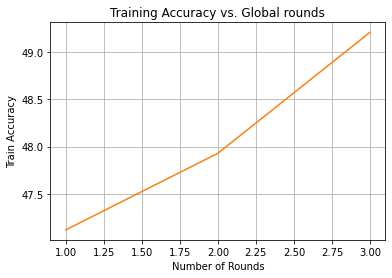

In [18]:
# number of training rounds
rounds = 3
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 3
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)
d={}

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

distilbert_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [18]:
def calcuate_accuracy(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

In [19]:
#Testing the trained model

def valid(model, testing_loader, loss_function):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [21]:
import pickle

print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(distilbert_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

d['train_acc'] = train_acc
d['test_acc'] = acc


with open(f'/content/drive/My Drive/DistilBERT/DPFLDistilBERT_Dep_eps15.pkl', 'wb') as file:
  pickle.dump(d, file)

7it [00:00, 60.10it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 1.3832507133483887
Validation Accuracy per 100 steps: 50.0


310it [00:05, 56.99it/s]

Validation Loss Epoch: 1.353612337573882
Validation Accuracy Epoch: 70.92084006462035
Accuracy on test data = 70.92%


/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full b

Training Loss per 5000 steps: 1.402402400970459
Training Accuracy per 5000 steps: 0.0


310it [00:21, 14.61it/s]
2it [00:00, 14.75it/s]

The Total Accuracy for Epoch 1: 21.719822365765037
Training Loss Epoch: 1.3895254162050064
Training Accuracy Epoch: 21.719822365765037
Training Loss per 5000 steps: 1.320266604423523
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.48it/s]
2it [00:00, 15.09it/s]

The Total Accuracy for Epoch 2: 21.154622527250705
Training Loss Epoch: 1.390037683133156
Training Accuracy Epoch: 21.154622527250705
Training Loss per 5000 steps: 1.4330902099609375
Training Accuracy per 5000 steps: 0.0


310it [00:21, 14.75it/s]
2it [00:00, 15.35it/s]

The Total Accuracy for Epoch 3: 21.03350827614049
Training Loss Epoch: 1.3889375225190193
Training Accuracy Epoch: 21.03350827614049
Training Loss per 5000 steps: 1.398986577987671
Training Accuracy per 5000 steps: 25.0


310it [00:20, 14.81it/s]
2it [00:00, 15.02it/s]

The Total Accuracy for Epoch 1: 22.163907953169158
Training Loss Epoch: 1.388755016173086
Training Accuracy Epoch: 22.163907953169158
Training Loss per 5000 steps: 1.423090934753418
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.74it/s]
2it [00:00, 15.26it/s]

The Total Accuracy for Epoch 2: 21.6794509487283
Training Loss Epoch: 1.3894454494599373
Training Accuracy Epoch: 21.6794509487283
Training Loss per 5000 steps: 1.3931554555892944
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.63it/s]
2it [00:00, 15.29it/s]

The Total Accuracy for Epoch 3: 21.92167945094873
Training Loss Epoch: 1.3880880555798931
Training Accuracy Epoch: 21.92167945094873
Training Loss per 5000 steps: 1.3497849702835083
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.71it/s]
2it [00:00, 15.06it/s]

The Total Accuracy for Epoch 1: 21.92167945094873
Training Loss Epoch: 1.390174739591537
Training Accuracy Epoch: 21.92167945094873
Training Loss per 5000 steps: 1.3560311794281006
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.76it/s]
2it [00:00, 15.23it/s]

The Total Accuracy for Epoch 2: 22.163907953169158
Training Loss Epoch: 1.3878772962477899
Training Accuracy Epoch: 22.163907953169158
Training Loss per 5000 steps: 1.4278675317764282
Training Accuracy per 5000 steps: 0.0


310it [00:21, 14.72it/s]
2it [00:00, 15.70it/s]

The Total Accuracy for Epoch 3: 22.28502220427937
Training Loss Epoch: 1.3903435999347318
Training Accuracy Epoch: 22.28502220427937
Training Loss per 5000 steps: 1.338129997253418
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.72it/s]
2it [00:00, 15.61it/s]

The Total Accuracy for Epoch 1: 23.415421881308035
Training Loss Epoch: 1.3873982133403902
Training Accuracy Epoch: 23.415421881308035
Training Loss per 5000 steps: 1.3836734294891357
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.70it/s]
2it [00:00, 15.21it/s]

The Total Accuracy for Epoch 2: 22.769479208720227
Training Loss Epoch: 1.385858351569022
Training Accuracy Epoch: 22.769479208720227
Training Loss per 5000 steps: 1.330274224281311
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.71it/s]
2it [00:00, 15.36it/s]

The Total Accuracy for Epoch 3: 23.33467904723456
Training Loss Epoch: 1.3868583517689859
Training Accuracy Epoch: 23.33467904723456
Training Loss per 5000 steps: 1.3694332838058472
Training Accuracy per 5000 steps: 0.0


310it [00:21, 14.70it/s]
2it [00:00, 15.22it/s]

The Total Accuracy for Epoch 1: 23.6980218005652
Training Loss Epoch: 1.388330824528971
Training Accuracy Epoch: 23.6980218005652
Training Loss per 5000 steps: 1.3745925426483154
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.70it/s]
2it [00:00, 15.38it/s]

The Total Accuracy for Epoch 2: 23.011707710940655
Training Loss Epoch: 1.3860745626111184
Training Accuracy Epoch: 23.011707710940655
Training Loss per 5000 steps: 1.3493244647979736
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.74it/s]
2it [00:00, 14.97it/s]

The Total Accuracy for Epoch 3: 24.343964473153008
Training Loss Epoch: 1.3860811498857313
Training Accuracy Epoch: 24.343964473153008
Round: 1... 	Average Loss: 1.388
Round: 1... 	Average Accuracy: 22.584
Training Loss per 5000 steps: 1.3660929203033447
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.74it/s]
2it [00:00, 15.50it/s]

The Total Accuracy for Epoch 1: 21.517965280581347
Training Loss Epoch: 1.386331710892339
Training Accuracy Epoch: 21.517965280581347
Training Loss per 5000 steps: 1.4135346412658691
Training Accuracy per 5000 steps: 0.0


310it [00:21, 14.73it/s]
2it [00:00, 15.42it/s]

The Total Accuracy for Epoch 2: 23.253936213161083
Training Loss Epoch: 1.3888314408640707
Training Accuracy Epoch: 23.253936213161083
Training Loss per 5000 steps: 1.3900271654129028
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.72it/s]
2it [00:00, 15.18it/s]

The Total Accuracy for Epoch 3: 24.50545014129996
Training Loss Epoch: 1.387585078131768
Training Accuracy Epoch: 24.50545014129996
Training Loss per 5000 steps: 1.3421316146850586
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.74it/s]
2it [00:00, 15.26it/s]

The Total Accuracy for Epoch 1: 21.63907953169156
Training Loss Epoch: 1.3892180312064386
Training Accuracy Epoch: 21.63907953169156
Training Loss per 5000 steps: 1.3878943920135498
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.72it/s]
2it [00:00, 15.21it/s]

The Total Accuracy for Epoch 2: 22.365765038352848
Training Loss Epoch: 1.3871487559810762
Training Accuracy Epoch: 22.365765038352848
Training Loss per 5000 steps: 1.368804693222046
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.74it/s]
2it [00:00, 15.34it/s]

The Total Accuracy for Epoch 3: 22.89059345983044
Training Loss Epoch: 1.3867096020329384
Training Accuracy Epoch: 22.89059345983044
Training Loss per 5000 steps: 1.3565713167190552
Training Accuracy per 5000 steps: 0.0


310it [00:21, 14.71it/s]
2it [00:00, 14.99it/s]

The Total Accuracy for Epoch 1: 24.222850222042794
Training Loss Epoch: 1.3858311322427566
Training Accuracy Epoch: 24.222850222042794
Training Loss per 5000 steps: 1.3354212045669556
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.72it/s]
2it [00:00, 15.32it/s]

The Total Accuracy for Epoch 2: 25.555106984255147
Training Loss Epoch: 1.3842734571426145
Training Accuracy Epoch: 25.555106984255147
Training Loss per 5000 steps: 1.3770114183425903
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.72it/s]
2it [00:00, 15.12it/s]

The Total Accuracy for Epoch 3: 25.232135647961243
Training Loss Epoch: 1.3850020385557604
Training Accuracy Epoch: 25.232135647961243
Training Loss per 5000 steps: 1.4053170680999756
Training Accuracy per 5000 steps: 0.0


310it [00:21, 14.70it/s]
2it [00:00, 15.02it/s]

The Total Accuracy for Epoch 1: 24.949535728704078
Training Loss Epoch: 1.3864873463107694
Training Accuracy Epoch: 24.949535728704078
Training Loss per 5000 steps: 1.476731538772583
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.70it/s]
2it [00:00, 14.97it/s]

The Total Accuracy for Epoch 2: 22.648364957610013
Training Loss Epoch: 1.38656587600708
Training Accuracy Epoch: 22.648364957610013
Training Loss per 5000 steps: 1.3277788162231445
Training Accuracy per 5000 steps: 50.0


310it [00:21, 14.70it/s]
2it [00:00, 15.07it/s]

The Total Accuracy for Epoch 3: 24.182478805006056
Training Loss Epoch: 1.3851832570568208
Training Accuracy Epoch: 24.182478805006056
Training Loss per 5000 steps: 1.4222362041473389
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.71it/s]
2it [00:00, 15.22it/s]

The Total Accuracy for Epoch 1: 24.70730722648365
Training Loss Epoch: 1.3831915486243462
Training Accuracy Epoch: 24.70730722648365
Training Loss per 5000 steps: 1.373698115348816
Training Accuracy per 5000 steps: 0.0


310it [00:21, 14.69it/s]
2it [00:00, 15.37it/s]

The Total Accuracy for Epoch 2: 23.73839321760194
Training Loss Epoch: 1.3861356446819921
Training Accuracy Epoch: 23.73839321760194
Training Loss per 5000 steps: 1.4716377258300781
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.70it/s]
2it [00:00, 14.83it/s]

The Total Accuracy for Epoch 3: 25.31287848203472
Training Loss Epoch: 1.3842867335965556
Training Accuracy Epoch: 25.31287848203472
Round: 2... 	Average Loss: 1.386
Round: 2... 	Average Accuracy: 24.425
Training Loss per 5000 steps: 1.4040007591247559
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.72it/s]
2it [00:00, 15.24it/s]

The Total Accuracy for Epoch 1: 24.545821558336698
Training Loss Epoch: 1.3866679633817365
Training Accuracy Epoch: 24.545821558336698
Training Loss per 5000 steps: 1.3924976587295532
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.70it/s]
2it [00:00, 15.25it/s]

The Total Accuracy for Epoch 2: 24.90916431166734
Training Loss Epoch: 1.3845440895326675
Training Accuracy Epoch: 24.90916431166734
Training Loss per 5000 steps: 1.3595609664916992
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.69it/s]
2it [00:00, 15.53it/s]

The Total Accuracy for Epoch 3: 23.657650383528463
Training Loss Epoch: 1.385974016497212
Training Accuracy Epoch: 23.657650383528463
Training Loss per 5000 steps: 1.4121882915496826
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.69it/s]
2it [00:00, 15.08it/s]

The Total Accuracy for Epoch 1: 24.424707307226484
Training Loss Epoch: 1.3849552516014345
Training Accuracy Epoch: 24.424707307226484
Training Loss per 5000 steps: 1.400738000869751
Training Accuracy per 5000 steps: 0.0


310it [00:21, 14.55it/s]
2it [00:00, 15.26it/s]

The Total Accuracy for Epoch 2: 23.89987888574889
Training Loss Epoch: 1.3864353083795118
Training Accuracy Epoch: 23.89987888574889
Training Loss per 5000 steps: 1.3424931764602661
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.56it/s]
2it [00:00, 15.31it/s]

The Total Accuracy for Epoch 3: 23.94025030278563
Training Loss Epoch: 1.384697070044856
Training Accuracy Epoch: 23.94025030278563
Training Loss per 5000 steps: 1.3580061197280884
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.52it/s]
2it [00:00, 14.98it/s]

The Total Accuracy for Epoch 1: 24.545821558336698
Training Loss Epoch: 1.3835162774209053
Training Accuracy Epoch: 24.545821558336698
Training Loss per 5000 steps: 1.3914377689361572
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.55it/s]
2it [00:00, 15.40it/s]

The Total Accuracy for Epoch 2: 24.061364553895842
Training Loss Epoch: 1.3851902542575714
Training Accuracy Epoch: 24.061364553895842
Training Loss per 5000 steps: 1.373231053352356
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.56it/s]
2it [00:00, 15.51it/s]

The Total Accuracy for Epoch 3: 25.191764230924505
Training Loss Epoch: 1.3837871082367437
Training Accuracy Epoch: 25.191764230924505
Training Loss per 5000 steps: 1.3325392007827759
Training Accuracy per 5000 steps: 37.5


310it [00:21, 14.52it/s]
2it [00:00, 15.11it/s]

The Total Accuracy for Epoch 1: 24.343964473153008
Training Loss Epoch: 1.384093947179856
Training Accuracy Epoch: 24.343964473153008
Training Loss per 5000 steps: 1.3469613790512085
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.50it/s]
2it [00:00, 15.18it/s]

The Total Accuracy for Epoch 2: 24.747678643520388
Training Loss Epoch: 1.3849870512562414
Training Accuracy Epoch: 24.747678643520388
Training Loss per 5000 steps: 1.3401143550872803
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.51it/s]
2it [00:00, 15.13it/s]

The Total Accuracy for Epoch 3: 24.626564392410174
Training Loss Epoch: 1.3833724714094593
Training Accuracy Epoch: 24.626564392410174
Training Loss per 5000 steps: 1.4012653827667236
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.53it/s]
2it [00:00, 15.15it/s]

The Total Accuracy for Epoch 1: 23.859507468712152
Training Loss Epoch: 1.3847369090203316
Training Accuracy Epoch: 23.859507468712152
Training Loss per 5000 steps: 1.4302380084991455
Training Accuracy per 5000 steps: 12.5


310it [00:21, 14.55it/s]
2it [00:00, 14.90it/s]

The Total Accuracy for Epoch 2: 25.31287848203472
Training Loss Epoch: 1.383963687958256
Training Accuracy Epoch: 25.31287848203472
Training Loss per 5000 steps: 1.3766535520553589
Training Accuracy per 5000 steps: 25.0


310it [00:21, 14.52it/s]


The Total Accuracy for Epoch 3: 23.73839321760194
Training Loss Epoch: 1.38450731654321
Training Accuracy Epoch: 23.73839321760194
Round: 3... 	Average Loss: 1.384
Round: 3... 	Average Accuracy: 24.231
Training Done!
Total time taken to Train: 952.6356835365295


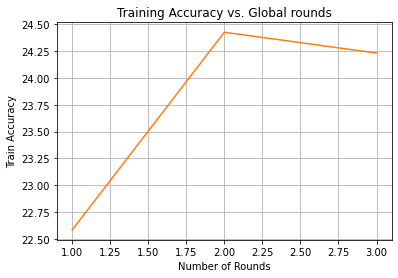

In [20]:
# number of training rounds
rounds = 3
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 3
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
d={}
#iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()
#model = 
if torch.cuda.is_available():
  model.cuda()

distilbert_non_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [21]:
import pickle
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(distilbert_non_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)


d['train_acc'] = train_acc
d['test_acc'] = acc


with open(f'/content/drive/My Drive/DistilBERT/DPFLDistilBERT_Dep_eps15_noniid.pkl', 'wb') as file:
  pickle.dump(d, file)

7it [00:00, 60.95it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 1.3184700012207031
Validation Accuracy per 100 steps: 0.0


310it [00:05, 56.59it/s]

Validation Loss Epoch: 1.3884412792421157
Validation Accuracy Epoch: 5.008077544426494
Accuracy on test data = 5.01%
